In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

In [ ]:
# read csv
black_images = pd.read_csv("/content/drive/Shareddrives/DAT490 Capstone/Data Files/black_images.csv")
modis_data = pd.read_csv("/content/drive/Shareddrives/DAT490 Capstone/Data Files/confirmed_US_fires_MODIS.csv")

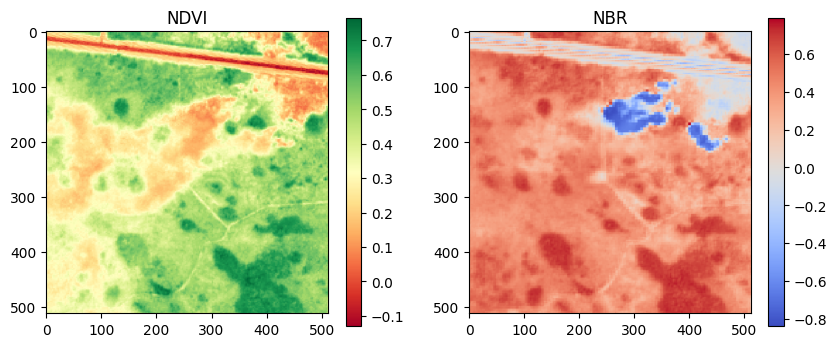

In [ ]:
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt

def normalize_band(band):
    """Normalize image data to range [0,1] assuming input is 8-bit (0-255)."""
    return band.astype(np.float32) / 255.0  # Adjust if different scaling is used

def compute_index(nir, other_band):
    """Compute NDVI or NBR using the standard formula."""
    return (nir - other_band) / (nir + other_band + 1e-10)

def extract_ndvi_nbr(png_path):
    """Extract NDVI and NBR from a Sentinel-2 PNG image."""

    image = np.array(Image.open(png_path))

    swir = normalize_band(image[:, :, 0])
    nir = normalize_band(image[:, :, 1])
    red = normalize_band(image[:, :, 2])

    ndvi = compute_index(nir, red)
    nbr = compute_index(nir, swir)

    return ndvi, nbr

ndvi, nbr = extract_ndvi_nbr("/content/drive/Shareddrives/DAT490 Capstone/Data Files/satellite_images/batch_3/26.2872_-81.0368_20220329_Infrared.png")

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(ndvi, cmap='RdYlGn')
plt.title("NDVI")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(nbr, cmap='coolwarm')
plt.title("NBR")
plt.colorbar()
plt.show()


In [ ]:
import os
import numpy as np
import cv2
import glob

def compute_indices(image_path):
    """Reads an infrared image and computes NDVI and NBR."""
    img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    img = img.astype(np.float32) / 255.0

    B12, B08, B04 = img[:,:,0], img[:,:,1], img[:,:,2]

    # Compute NDVI
    ndvi = (B08 - B04) / (B08 + B04 + 1e-6)

    # Compute NBR
    nbr = (B08 - B12) / (B08 + B12 + 1e-6)

    return ndvi, nbr

def process_all_images(image_folder, output_folder):
    """Computes NDVI and NBR for all images labeled 'InfraredTrue' and saves them."""
    os.makedirs(output_folder, exist_ok=True)

    ndvi_list = []
    nbr_list = []


    for img_path in glob.glob(os.path.join(image_folder, "*InfraredTrue*.png")):
        ndvi, nbr = compute_indices(img_path)

        filename = os.path.basename(img_path).replace(".png", ".npy")
        np.save(os.path.join(output_folder, f"ndvi_{filename}"), ndvi)
        np.save(os.path.join(output_folder, f"nbr_{filename}"), nbr)

        ndvi_list.append(ndvi)
        nbr_list.append(nbr)

    return np.array(ndvi_list), np.array(nbr_list)

image_folder = "/content/drive/Shareddrives/DAT490 Capstone/Data Files/satellite_images/batch_9"
output_folder = "/content/drive/Shareddrives/DAT490 Capstone/Data Files/satellite_images/batch_9_NDVI_and_NBR"
ndvi_data, nbr_data = process_all_images(image_folder, output_folder)


In [ ]:
import numpy as np
import os
from sklearn.model_selection import train_test_split

def load_preprocessed_images(folder):
    """Loads saved NDVI & NBR arrays and sorts them by date."""
    ndvi_files = sorted([f for f in os.listdir(folder) if f.startswith("ndvi_")])
    nbr_files = sorted([f for f in os.listdir(folder) if f.startswith("nbr_")])

    ndvi_images = [np.load(os.path.join(folder, f)) for f in ndvi_files]
    nbr_images = [np.load(os.path.join(folder, f)) for f in nbr_files]

    data = np.stack([ndvi_images, nbr_images], axis=-1)

    return data

def create_sequences(data, seq_length=5):
    """Creates input-output sequences for the CNN-RNN model."""
    sequences = []
    targets = []

    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        targets.append(data[i+seq_length])

    return np.array(sequences), np.array(targets)

# Directory
data_folder = "/content/drive/Shareddrives/DAT490 Capstone/Data Files/satellite_images/batch_9_NDVI_and_NBR"
data = load_preprocessed_images(data_folder)


X, y = create_sequences(data, seq_length=5)

# Split 80-20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
y_train = np.expand_dims(y_train, axis=1)

print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

"""
For reduced computational power run this:
import numpy as np
import os
from sklearn.model_selection import train_test_split

def load_preprocessed_images(folder, max_images=10):
    "\""Loads saved NDVI & NBR arrays and sorts them by date, limited to max_images."\""
    ndvi_files = sorted([f for f in os.listdir(folder) if f.startswith("ndvi_")])[:max_images]
    nbr_files = sorted([f for f in os.listdir(folder) if f.startswith("nbr_")])[:max_images]

    ndvi_images = [np.load(os.path.join(folder, f)) for f in ndvi_files]
    nbr_images = [np.load(os.path.join(folder, f)) for f in nbr_files]

    # Stack NDVI & NBR as channels: Shape (time, H, W, 2)
    data = np.stack([ndvi_images, nbr_images], axis=-1)

    return data

def create_sequences(data, seq_length=5):
    "\""Creates input-output sequences for the CNN-RNN model."\""
    sequences = []
    targets = []

    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])  # Past frames as input
        targets.append(data[i+seq_length])      # Next frame as label

    return np.array(sequences), np.array(targets)

# Load the images (only first 10)
data_folder = "satellite_images/batch_9_NDVI_and_NBR"
data = load_preprocessed_images(data_folder, max_images=10)

# Ensure there are enough frames to create sequences
if len(data) > 5:
    # Create sequences (past 5 frames -> next frame)
    X, y = create_sequences(data, seq_length=5)

    # Split into train (80%) and test (20%)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    y_train = np.expand_dims(y_train, axis=1)
    X_train = X_train.astype("float16")
    y_train = y_train.astype("float16")

    print("Training data shape:", X_train.shape)
    print("Test data shape:", X_test.shape)
else:
    print("Not enough images to create sequences.")
"""

Training data shape: (51, 5, 512, 512, 2)
Test data shape: (13, 5, 512, 512, 2)


'\nFor reduced computational power run this:\nimport numpy as np\nimport os\nfrom sklearn.model_selection import train_test_split\n\ndef load_preprocessed_images(folder, max_images=10):\n    """Loads saved NDVI & NBR arrays and sorts them by date, limited to max_images."""\n    ndvi_files = sorted([f for f in os.listdir(folder) if f.startswith("ndvi_")])[:max_images]\n    nbr_files = sorted([f for f in os.listdir(folder) if f.startswith("nbr_")])[:max_images]\n\n    ndvi_images = [np.load(os.path.join(folder, f)) for f in ndvi_files]\n    nbr_images = [np.load(os.path.join(folder, f)) for f in nbr_files]\n\n    # Stack NDVI & NBR as channels: Shape (time, H, W, 2)\n    data = np.stack([ndvi_images, nbr_images], axis=-1)\n\n    return data\n\ndef create_sequences(data, seq_length=5):\n    """Creates input-output sequences for the CNN-RNN model."""\n    sequences = []\n    targets = []\n\n    for i in range(len(data) - seq_length):\n        sequences.append(data[i:i+seq_length])  # Past 

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, BatchNormalization, Conv3D, Lambda

seq_length = 5
img_height, img_width = X_train.shape[2], X_train.shape[3]
num_channels = X_train.shape[4]

#ConvLSTM
model = Sequential([
    ConvLSTM2D(filters=64, kernel_size=(3, 3), activation="relu",
               padding="same", return_sequences=True, input_shape=(seq_length, img_height, img_width, num_channels)),
    BatchNormalization(),

    ConvLSTM2D(filters=64, kernel_size=(3, 3), activation="relu",
               padding="same", return_sequences=True),
    BatchNormalization(),

    ConvLSTM2D(filters=64, kernel_size=(3, 3), activation="relu",
               padding="same", return_sequences=False),
    BatchNormalization(),

    Lambda(lambda x: tf.expand_dims(x, axis=1)),

    Conv3D(filters=2, kernel_size=(3, 3, 3), activation="sigmoid",
           padding="same", data_format="channels_last")
])

#Complile
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)        │ (None, 5, 512, 512,    │       152,320 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 5, 512, 512,    │           256 │
│ (BatchNormalization)            │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)      │ (None, 5, 512, 512,    │       295,168 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 5, 512, 512,    │           256 │
│ (BatchNormalization)            │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_2 (ConvLSTM2D)      │ (None, 512, 512, 64)   │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 512, 512, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 1, 512, 512,    │             0 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d (Conv3D)                 │ (None, 1, 512, 512, 2) │         3,458 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 746,882 (2.85 MB)

 Trainable params: 746,498 (2.85 MB)

 Non-trainable params: 384 (1.50 KB)

In [ ]:
batch_size = 2
epochs = 5

# Train
history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_test, y_test),
    verbose=1
)


Epoch 1/5


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    ConvLSTM2D, BatchNormalization, Conv3D, LSTM, Dense, Dropout, Flatten,
    TimeDistributed, Input, concatenate
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

weather_data = pd.read_csv("/content/drive/Shareddrives/DAT490 Capstone/Data Files/new_weather_data.csv")

weather_features = ["precipitation", "wind_speed", "wind_direction"]
scaler = StandardScaler()
weather_data[weather_features] = scaler.fit_transform(weather_data[weather_features])

# Convert weather data to time-series data
def create_weather_sequences(data, seq_length=5):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length].values)
        targets.append(data.iloc[i+seq_length]["precipitation"])
    return np.array(sequences), np.array(targets)

weather_sequences, weather_targets = create_weather_sequences(weather_data)

# Load NDVI/NBR
def load_preprocessed_images(folder):
    ndvi_files = sorted([f for f in os.listdir(folder) if f.startswith("ndvi_")])
    nbr_files = sorted([f for f in os.listdir(folder) if f.startswith("nbr_")])
    ndvi_images = [np.load(os.path.join(folder, f)) for f in ndvi_files]
    nbr_images = [np.load(os.path.join(folder, f)) for f in nbr_files]
    return np.stack([ndvi_images, nbr_images], axis=-1)

image_folder = "/content/drive/Shareddrives/DAT490 Capstone/Data Files/satellite_images/batch_9_NDVI_and_NBR"
image_data = load_preprocessed_images(image_folder)

#CNN-LSTM sequences
X_img, y_img = create_weather_sequences(pd.DataFrame(image_data.reshape(image_data.shape[0], -1)), seq_length=5)
X_img = X_img.reshape(X_img.shape[0], 5, 128, 128, 2)  # Adjust image dimensions

# Split 80-20
X_img_train, X_img_test, y_img_train, y_img_test = train_test_split(X_img, y_img, test_size=0.2, shuffle=False)
X_w_train, X_w_test, y_w_train, y_w_test = train_test_split(weather_sequences, weather_targets, test_size=0.2, shuffle=False)

#CNN-LSTM for image processing
img_input = Input(shape=(5, 128, 128, 2))
x = ConvLSTM2D(filters=64, kernel_size=(3, 3), activation="relu", padding="same", return_sequences=True)(img_input)
x = BatchNormalization()(x)
x = ConvLSTM2D(filters=64, kernel_size=(3, 3), activation="relu", padding="same", return_sequences=False)(x)
x = BatchNormalization()(x)
x = Flatten()(x)
img_output = Dense(64, activation="relu")(x)

#LSTM for weather data
weather_input = Input(shape=(5, 3))
y = LSTM(64, return_sequences=True)(weather_input)
y = Dropout(0.2)(y)
y = LSTM(32, return_sequences=False)(y)
y = Dense(64, activation="relu")(y)

# Merge
merged = concatenate([img_output, y])
final_output = Dense(1, activation="sigmoid")(merged)  # Predict probability of fire intensity

# Compile
hybrid_model = Model(inputs=[img_input, weather_input], outputs=final_output)
hybrid_model.compile(optimizer="adam", loss="mse", metrics=["mae"])

hybrid_model.fit([X_img_train, X_w_train], y_img_train, batch_size=4, epochs=10, validation_data=([X_img_test, X_w_test], y_img_test))

hybrid_model.summary()


KeyError: 'precipitation'

In [ ]:
#WORKING CODE SEGEMENT #------------------------------------------------------
import numpy as np
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, BatchNormalization, Conv2D

#Load NDVI/NBR
def load_preprocessed_images(folder, max_images=None):
    """Load NDVI and NBR .npy files and stack them by date."""
    ndvi_files = sorted([f for f in os.listdir(folder) if f.startswith("ndvi_")])
    nbr_files = sorted([f for f in os.listdir(folder) if f.startswith("nbr_")])
    assert len(ndvi_files) == len(nbr_files), "NDVI and NBR file counts must match"
    if max_images:
        ndvi_files = ndvi_files[:max_images]
        nbr_files = nbr_files[:max_images]

    ndvi_images = [np.load(os.path.join(folder, f)) for f in ndvi_files]
    nbr_images = [np.load(os.path.join(folder, f)) for f in nbr_files]

    data = np.stack([ndvi_images, nbr_images], axis=-1)
    return data

def create_sequences(data, seq_length):
    """Create input-output sequences: X (past seq_length frames), y (next frame)."""
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

data_folder = "/content/drive/Shareddrives/DAT490 Capstone/Data Files/satellite_images/batch_9_reduced_NDVI_and_NBR"
data = load_preprocessed_images(data_folder, max_images=10)
print("Raw data shape:", data.shape)

# Create sequences
seq_length = 5
X, y = create_sequences(data, seq_length)
print("X shape:", X.shape)
print("y shape:", y.shape)

#Split 80-200
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train = X_train.astype("float32")
y_train = y_train.astype("float32")
X_test = X_test.astype("float32")
y_test = y_test.astype("float32")
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

#Model
model = Sequential([
    ConvLSTM2D(filters=32, kernel_size=(3, 3), activation="relu", padding="same",
               input_shape=(seq_length, X.shape[2], X.shape[3], X.shape[4]), return_sequences=False),
    BatchNormalization(),
    Conv2D(filters=2, kernel_size=(3, 3), activation="sigmoid", padding="same")
])

# Compile
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["mae"])  # MAE for regression-like task
model.summary()

batch_size = 1
epochs = 10
dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_data = (X_test, y_test)

history = model.fit(dataset, epochs=epochs, validation_data=val_data, verbose=1)

In [ ]:
### THIS ONE KILLS THE KERNEL IN JUYPTER SO IT MIGHT NOT WORK HERE
### THIS CODE SECTION HOWEVER DOES INTEGRATE WEATHER DATA INTO THE MODEL
import numpy as np
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import ConvLSTM2D, BatchNormalization, Conv2D, Input, Dense, Concatenate, Reshape, TimeDistributed
import pandas as pd
from datetime import datetime

#Load NDVI/NBR
def load_preprocessed_images_and_weather(img_folder, csv_path, max_images=None):
    """Load NDVI/NBR images and align with weather data based on filename dates."""
    ndvi_files = sorted([f for f in os.listdir(img_folder) if f.startswith("ndvi_")])
    if max_images:
        ndvi_files = ndvi_files[:max_images]

    dates = [f.split('_')[3] for f in ndvi_files]
    ndvi_images = [np.load(os.path.join(img_folder, f)) for f in ndvi_files]
    nbr_files = [f.replace("ndvi_", "nbr_") for f in ndvi_files]
    nbr_images = [np.load(os.path.join(img_folder, f)) for f in nbr_files]

    img_data = np.stack([ndvi_images, nbr_images], axis=-1)

    weather_df = load_weather_data(csv_path)
    weather_data = weather_df.loc[dates].values

    return img_data, weather_data

def load_weather_data(csv_path):
    """Load CSV and convert dates to YYYYMMDD strings."""
    df = pd.read_csv(csv_path)
    df['date'] = pd.to_datetime(df['date'], format='%Y%m%d').dt.strftime('%Y%m%d')
    weather = df[['date', 'precipitation', 'wind_speed', 'wind_direction']].set_index('date')
    return weather

def normalize_weather(weather_data):
    """Normalize weather data to [0, 1]."""
    mins = weather_data.min(axis=0)
    maxs = weather_data.max(axis=0)
    return (weather_data - mins) / (maxs - mins + 1e-6)

def create_sequences(img_data, weather_data, seq_length):
    """Create sequences for images and weather."""
    X_img, X_weather, y = [], [], []
    for i in range(len(img_data) - seq_length):
        X_img.append(img_data[i:i + seq_length])
        X_weather.append(weather_data[i:i + seq_length])
        y.append(img_data[i + seq_length])
    return np.array(X_img), np.array(X_weather), np.array(y)

# Load data
data_folder = "/content/drive/Shareddrives/DAT490 Capstone/Data Files/satellite_images/batch_9_reduced_NDVI_and_NBR"
csv_path = "/content/drive/Shareddrives/DAT490 Capstone/Data Files/weather_data_hawaii.csv"
img_data, weather_data = load_preprocessed_images_and_weather(data_folder, csv_path, max_images=10)
weather_data = normalize_weather(weather_data)
print("Image data shape:", img_data.shape)
print("Weather data shape:", weather_data.shape)

# Create sequences
seq_length = 5
X_img, X_weather, y = create_sequences(img_data, weather_data, seq_length)
print("X_img shape:", X_img.shape)
print("X_weather shape:", X_weather.shape)
print("y shape:", y.shape)

# Split 80-20
X_img_train, X_img_test, X_weather_train, X_weather_test, y_train, y_test = train_test_split(
    X_img, X_weather, y, test_size=0.2, shuffle=False
)
X_img_train = X_img_train.astype("float32")
X_weather_train = X_weather_train.astype("float32")
y_train = y_train.astype("float32")
X_img_test = X_img_test.astype("float32")
X_weather_test = X_weather_test.astype("float32")
y_test = y_test.astype("float32")

# Model
img_input = Input(shape=(seq_length, 256, 256, 2), name="img_input")
weather_input = Input(shape=(seq_length, 3), name="weather_input")

conv_lstm = ConvLSTM2D(filters=32, kernel_size=(3, 3), activation="relu", padding="same",
                       return_sequences=False)(img_input)
conv_lstm = BatchNormalization()(conv_lstm)


flat_features = tf.keras.layers.Flatten()(conv_lstm)


weather_processed = TimeDistributed(Dense(16, activation="relu"))(weather_input)
weather_flat = tf.keras.layers.Flatten()(weather_processed)

# Combine
combined = Concatenate()([flat_features, weather_flat])

dense = Dense(256 * 256 * 2, activation="sigmoid")(combined)
output = Reshape((256, 256, 2))(dense)

# Model
model = Model(inputs=[img_input, weather_input], outputs=output)
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["mae"])
model.summary()

batch_size = 1
epochs = 10
dataset = tf.data.Dataset.from_tensor_slices(((X_img_train, X_weather_train), y_train)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_data = ([X_img_test, X_weather_test], y_test)

history = model.fit(dataset, epochs=epochs, validation_data=val_data, verbose=1)

In [ ]:
#UPDATED RUNABLE MODEL ** NO DENSE LAYER ** MEDIOCRE ACCURACY
import numpy as np
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import ConvLSTM2D, BatchNormalization, Conv2D, Input, Dense, Concatenate, TimeDistributed, Reshape, Dropout
import pandas as pd

#Load NDVI/NBR
def load_preprocessed_images_and_weather(img_folder, csv_path, max_images=None):
    ndvi_files = sorted([f for f in os.listdir(img_folder) if f.startswith("ndvi_")])
    if max_images:
        ndvi_files = ndvi_files[:max_images]
    dates = [f.split('_')[3] for f in ndvi_files]
    ndvi_images = [np.load(os.path.join(img_folder, f)) for f in ndvi_files]
    nbr_files = [f.replace("ndvi_", "nbr_") for f in ndvi_files]
    nbr_images = [np.load(os.path.join(img_folder, f)) for f in nbr_files]
    img_data = np.stack([ndvi_images, nbr_images], axis=-1)
    weather_df = load_weather_data(csv_path)
    weather_data = weather_df.loc[dates].values
    return img_data, weather_data

def load_weather_data(csv_path):
    df = pd.read_csv(csv_path)
    df['date'] = pd.to_datetime(df['date'], format='%Y%m%d').dt.strftime('%Y%m%d')
    weather = df[['date', 'precipitation', 'wind_speed', 'wind_direction']].set_index('date')
    return weather

def normalize_weather(weather_data):
    mins = weather_data.min(axis=0)
    maxs = weather_data.max(axis=0)
    return (weather_data - mins) / (maxs - mins + 1e-6)

def create_sequences(img_data, weather_data, seq_length):
    X_img, X_weather, y = [], [], []
    for i in range(len(img_data) - seq_length):
        X_img.append(img_data[i:i + seq_length])
        X_weather.append(weather_data[i:i + seq_length])
        y.append(img_data[i + seq_length])
    return np.array(X_img), np.array(X_weather), np.array(y)

# Load data
data_folder = "/content/drive/Shareddrives/DAT490 Capstone/Data Files/satellite_images/batch_9_reduced_NDVI_and_NBR"
csv_path = "/content/drive/Shareddrives/DAT490 Capstone/Data Files/weather_data_hawaii.csv"
img_data, weather_data = load_preprocessed_images_and_weather(data_folder, csv_path, max_images=None)
weather_data = normalize_weather(weather_data)
print("Image data shape:", img_data.shape)
print("Weather data shape:", weather_data.shape)

# Create sequences
seq_length = 5
X_img, X_weather, y = create_sequences(img_data, weather_data, seq_length)
print("X_img shape:", X_img.shape)
print("X_weather shape:", X_weather.shape)
print("y shape:", y.shape)

# Split 80-20
X_img_train, X_img_test, X_weather_train, X_weather_test, y_train, y_test = train_test_split(
    X_img, X_weather, y, test_size=0.2, shuffle=False
)
X_img_train = X_img_train.astype("float32")
X_weather_train = X_weather_train.astype("float32")
y_train = y_train.astype("float32")
X_img_test = X_img_test.astype("float32")
X_weather_test = X_weather_test.astype("float32")
y_test = y_test.astype("float32")

# Model
img_input = Input(shape=(seq_length, 256, 256, 2), name="img_input", dtype=tf.float32)
weather_input = Input(shape=(seq_length, 3), name="weather_input", dtype=tf.float32)

# ConvLSTM
conv_lstm = ConvLSTM2D(filters=32, kernel_size=(3, 3), activation="relu", padding="same",
                       return_sequences=True, dropout=0.2, recurrent_dropout=0.2)(img_input)
conv_lstm = ConvLSTM2D(filters=32, kernel_size=(3, 3), activation="relu", padding="same",
                       return_sequences=False, dropout=0.2, recurrent_dropout=0.2)(conv_lstm)
conv_lstm = BatchNormalization()(conv_lstm)

# Weather processing
weather_processed = TimeDistributed(Dense(8, activation="relu"))(weather_input)
weather_processed = Dropout(0.2)(weather_processed)
weather_lstm = tf.keras.layers.LSTM(16, dropout=0.2, recurrent_dropout=0.2)(weather_processed)
weather_tiled = Dense(256 * 256 * 4, activation="relu")(weather_lstm)
weather_reshaped = Reshape((256, 256, 4))(weather_tiled)
weather_reshaped = Conv2D(filters=4, kernel_size=(3, 3), activation="relu", padding="same")(weather_reshaped)

# Combine
combined = Concatenate(axis=-1)([conv_lstm, weather_reshaped])
combined = Conv2D(filters=16, kernel_size=(3, 3), activation="relu", padding="same")(combined)
output = Conv2D(filters=2, kernel_size=(3, 3), activation="sigmoid", padding="same",
                bias_initializer=tf.keras.initializers.Constant(0.5))(combined)

# Model
model = Model(inputs=[img_input, weather_input], outputs=output)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss="mse", metrics=["mae"])
model.summary()

# Training
batch_size = 1
epochs = 20
dataset = tf.data.Dataset.from_tensor_slices(((X_img_train, X_weather_train), y_train)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_data = ([X_img_test, X_weather_test], y_test)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_mae", patience=5, restore_best_weights=True)

history = model.fit(dataset, epochs=epochs, validation_data=val_data, verbose=1, callbacks=[early_stopping])

# Visualization
import matplotlib.pyplot as plt
predictions = model.predict(val_data[0])
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1); plt.imshow(y_test[0, :, :, 0]); plt.title("Actual NDVI")
plt.subplot(1, 3, 2); plt.imshow(predictions[0, :, :, 0]); plt.title("Predicted NDVI")
plt.subplot(1, 3, 3); plt.imshow(np.abs(y_test[0, :, :, 0] - predictions[0, :, :, 0])); plt.title("Error")
plt.show()

Image data shape: (69, 256, 256, 2)
Weather data shape: (69, 3)
X_img shape: (64, 5, 256, 256, 2)
X_weather shape: (64, 5, 3)
y shape: (64, 256, 256, 2)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ weather_input       │ (None, 5, 3)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 5, 8)      │         32 │ weather_input[0]… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 5, 8)      │          0 │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ img_input           │ (None, 5, 256,    │          0 │ -                 │
│ (InputLayer)        │ 256, 2)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 16)        │      1,600 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d_3       │ (None, 5, 256,    │     39,296 │ img_input[0][0]   │
│ (ConvLSTM2D)        │ 256, 32)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 262144)    │  4,456,448 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d_4       │ (None, 256, 256,  │     73,856 │ conv_lstm2d_3[0]… │
│ (ConvLSTM2D)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 256, 256,  │          0 │ dense_1[0][0]     │
│                     │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv_lstm2d_4[0]… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        148 │ reshape[0][0]     │
│                     │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Concatenate)       │ 36)               │            │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      5,200 │ concatenate[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 256, 256,  │        290 │ conv2d_1[0][0]    │
│                     │ 2)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,576,998 (17.46 MB)

 Trainable params: 4,576,934 (17.46 MB)

 Non-trainable params: 64 (256.00 B)

Epoch 1/20
 1/51 ━━━━━━━━━━━━━━━━━━━━ 27:25 33s/step - loss: 0.4795 - mae: 0.6645

KeyboardInterrupt: 

In [ ]:
#Best model so far!
#includes a bias term to make the fire more predictided
#feel free to build off of this!
import numpy as np
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import ConvLSTM2D, BatchNormalization, Conv2D, Input, Dense, Concatenate, TimeDistributed, Reshape, Dropout
import pandas as pd
import matplotlib.pyplot as plt

# Focal Loss Function
def focal_loss(gamma=2.0, alpha=0.75):
    def focal_loss_fixed(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-5, 1 - 1e-5)
        pt = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        pt = tf.clip_by_value(pt, 1e-5, 1 - 1e-5)
        log_pt = tf.math.log(pt)
        focal_term = tf.pow(1 - pt, gamma)
        loss = -alpha * y_true * focal_term * log_pt
        loss += -(1 - alpha) * (1 - y_true) * focal_term * tf.math.log(1 - pt)
        loss = tf.where(tf.math.is_nan(loss), tf.zeros_like(loss), loss)
        return tf.reduce_mean(loss)
    return focal_loss_fixed

# Load NDVI/NBR
def load_preprocessed_images_and_weather(img_folder, csv_path, max_images=None):
    ndvi_files = sorted([f for f in os.listdir(img_folder) if f.startswith("ndvi_")])
    if max_images:
        ndvi_files = ndvi_files[:max_images]
    dates = [f.split('_')[3] for f in ndvi_files]
    ndvi_images = [np.load(os.path.join(img_folder, f)) for f in ndvi_files]
    nbr_files = [f.replace("ndvi_", "nbr_") for f in ndvi_files]
    nbr_images = [np.load(os.path.join(img_folder, f)) for f in nbr_files]
    img_data = np.stack([ndvi_images, nbr_images], axis=-1)
    weather_df = load_weather_data(csv_path)
    weather_data = weather_df.loc[dates].values
    return img_data, weather_data

def load_weather_data(csv_path):
    df = pd.read_csv(csv_path)
    df['date'] = pd.to_datetime(df['date'], format='%Y%m%d').dt.strftime('%Y%m%d')
    weather = df[['date', 'precipitation', 'wind_speed', 'wind_direction']].set_index('date')
    return weather

def normalize_weather(weather_data):
    mins = weather_data.min(axis=0)
    maxs = weather_data.max(axis=0)
    return (weather_data - mins) / (maxs - mins + 1e-6)

def create_sequences(img_data, weather_data, seq_length):
    X_img, X_weather, y = [], [], []
    for i in range(len(img_data) - seq_length):
        X_img.append(img_data[i:i + seq_length])
        X_weather.append(weather_data[i:i + seq_length])
        y.append(img_data[i + seq_length])
    return np.array(X_img), np.array(X_weather), np.array(y)

def augment_data(inputs, y):
    X_img, X_weather = inputs
    mask = X_img > 0.5
    boost = tf.random.uniform([1], 1.0, 1.5, dtype=tf.float32)
    normal = tf.random.uniform([1], 0.9, 1.1, dtype=tf.float32)
    scale = tf.where(mask, boost, normal)
    X_img_aug = X_img * scale
    X_img_aug = tf.clip_by_value(X_img_aug, 0, 1)
    return (X_img_aug, X_weather), y

# Load data
data_folder = "/content/drive/Shareddrives/DAT490 Capstone/Data Files/satellite_images/batch_9_reduced_NDVI_and_NBR"
csv_path = "/content/drive/Shareddrives/DAT490 Capstone/Data Files/weather_data_hawaii.csv"
img_data, weather_data = load_preprocessed_images_and_weather(data_folder, csv_path, max_images=None)
weather_data = normalize_weather(weather_data)
print("Image data shape:", img_data.shape)
print("Weather data shape:", weather_data.shape)

# Create sequences
seq_length = 5
X_img, X_weather, y = create_sequences(img_data, weather_data, seq_length)
print("X_img shape:", X_img.shape)
print("X_weather shape:", X_weather.shape)
print("y shape:", y.shape)

# Split 80-20
X_img_train, X_img_test, X_weather_train, X_weather_test, y_train, y_test = train_test_split(
    X_img, X_weather, y, test_size=0.2, shuffle=False
)
X_img_train = X_img_train.astype("float32")
X_weather_train = X_weather_train.astype("float32")
y_train = y_train.astype("float32")
X_img_test = X_img_test.astype("float32")
X_weather_test = X_weather_test.astype("float32")
y_test = y_test.astype("float32")

# Check for NANs
print("NaN in X_img_train:", np.any(np.isnan(X_img_train)))
print("NaN in X_weather_train:", np.any(np.isnan(X_weather_train)))
print("NaN in y_train:", np.any(np.isnan(y_train)))
print("NaN in X_img_test:", np.any(np.isnan(X_img_test)))
print("NaN in X_weather_test:", np.any(np.isnan(X_weather_test)))
print("NaN in y_test:", np.any(np.isnan(y_test)))

# Model
img_input = Input(shape=(seq_length, 256, 256, 2), name="img_input", dtype=tf.float32)
weather_input = Input(shape=(seq_length, 3), name="weather_input", dtype=tf.float32)

# ConvLSTM
conv_lstm = ConvLSTM2D(filters=64, kernel_size=(3, 3), activation="relu", padding="same",
                       return_sequences=True, dropout=0.2, recurrent_dropout=0.2)(img_input)
conv_lstm = ConvLSTM2D(filters=64, kernel_size=(3, 3), activation="relu", padding="same",
                       return_sequences=False, dropout=0.2, recurrent_dropout=0.2)(conv_lstm)
conv_lstm = BatchNormalization()(conv_lstm)

# Weather processing
weather_processed = TimeDistributed(Dense(32, activation="relu"))(weather_input)
weather_processed = Dropout(0.2)(weather_processed)
weather_lstm = tf.keras.layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2)(weather_processed)
weather_tiled = Dense(256 * 256 * 8, activation="relu")(weather_lstm)
weather_reshaped = Reshape((256, 256, 8))(weather_tiled)
weather_reshaped = Conv2D(filters=8, kernel_size=(3, 3), dilation_rate=2, activation="relu", padding="same")(weather_reshaped)

# Combine
combined = Concatenate(axis=-1)([conv_lstm, weather_reshaped])
combined = Conv2D(filters=16, kernel_size=(3, 3), dilation_rate=2, activation="relu", padding="same")(combined)
output = Conv2D(filters=2, kernel_size=(3, 3), activation="sigmoid", padding="same",
                bias_initializer=tf.keras.initializers.Constant(1.0))(combined)

# Model
model = Model(inputs=[img_input, weather_input], outputs=output)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-5,
    decay_steps=1000,
    decay_rate=0.9
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, clipnorm=1.0)
model.compile(optimizer=optimizer, loss=focal_loss(gamma=2.0, alpha=0.75), metrics=["mae"])
model.summary()

# Training
batch_size = 1
epochs = 20
dataset = tf.data.Dataset.from_tensor_slices(((X_img_train, X_weather_train), y_train)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
dataset = dataset.map(augment_data, num_parallel_calls=tf.data.AUTOTUNE)
val_data = ([X_img_test, X_weather_test], y_test)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_mae", patience=5, min_delta=0.001, restore_best_weights=True)

history = model.fit(dataset, epochs=epochs, validation_data=val_data, verbose=1, callbacks=[early_stopping])

# Visualization
predictions = model.predict(val_data[0])
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1); plt.imshow(y_test[0, :, :, 0]); plt.title("Actual NDVI")
plt.subplot(1, 3, 2); plt.imshow(predictions[0, :, :, 0]); plt.title("Predicted NDVI")
plt.subplot(1, 3, 3); plt.imshow(np.abs(y_test[0, :, :, 0] - predictions[0, :, :, 0])); plt.title("Error")
plt.show()

Image data shape: (69, 256, 256, 2)
Weather data shape: (69, 3)
X_img shape: (64, 5, 256, 256, 2)
X_weather shape: (64, 5, 3)
y shape: (64, 256, 256, 2)
NaN in X_img_train: False
NaN in X_weather_train: False
NaN in y_train: False
NaN in X_img_test: False
NaN in X_weather_test: False
NaN in y_test: False


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ weather_input       │ (None, 5, 3)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1  │ (None, 5, 32)     │        128 │ weather_input[0]… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 5, 32)     │          0 │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ img_input           │ (None, 5, 256,    │          0 │ -                 │
│ (InputLayer)        │ 256, 2)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 64)        │     24,832 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d_5       │ (None, 5, 256,    │    152,320 │ img_input[0][0]   │
│ (ConvLSTM2D)        │ 256, 64)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 524288)    │ 34,078,720 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d_6       │ (None, 256, 256,  │    295,168 │ conv_lstm2d_5[0]… │
│ (ConvLSTM2D)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 256, 256,  │          0 │ dense_3[0][0]     │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv_lstm2d_6[0]… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 256, 256,  │        584 │ reshape_1[0][0]   │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Concatenate)       │ 72)               │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 256, 256,  │     10,384 │ concatenate_1[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 256, 256,  │        290 │ conv2d_4[0][0]    │
│                     │ 2)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 34,562,682 (131.85 MB)

 Trainable params: 34,562,554 (131.85 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 1837s 36s/step - loss: -0.1165 - mae: 0.7290 - val_loss: 0.0045 - val_mae: 0.6719
Epoch 2/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 1757s 34s/step - loss: -0.1247 - mae: 0.7302 - val_loss: 0.0044 - val_mae: 0.6721
Epoch 3/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 1795s 35s/step - loss: -0.1322 - mae: 0.7314 - val_loss: 0.0041 - val_mae: 0.6723
Epoch 4/20


In [ ]:
###WILDFIRE PREDICTION MODEL 2.5
###DIRECTORIES DO NEED TO BE CHANGED

import sys
import tensorflow as tf
import numpy as np
import os
import sklearn
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import ConvLSTM2D, BatchNormalization, Conv2D, Input, Dense, Concatenate, TimeDistributed, Reshape, Dropout
import pandas as pd
import matplotlib.pyplot as plt

def focal_loss(gamma=1.0, alpha=0.5):
    def focal_loss_fixed(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-5, 1 - 1e-5)
        pt = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        pt = tf.clip_by_value(pt, 1e-5, 1 - 1e-5)
        log_pt = tf.math.log(pt)
        focal_term = tf.pow(1 - pt, gamma)
        loss = -alpha * y_true * focal_term * log_pt
        loss += -(1 - alpha) * (1 - y_true) * focal_term * tf.math.log(1 - pt)
        loss = tf.where(tf.math.is_nan(loss), tf.zeros_like(loss), loss)
        return tf.reduce_mean(loss)
    return focal_loss_fixed

def fire_region_mae(y_true, y_pred):
    fire_mask = y_true < 0.3
    fire_mask = tf.cast(fire_mask, tf.float32)
    error = tf.abs(y_true - y_pred)
    fire_error = tf.reduce_sum(error * fire_mask) / (tf.reduce_sum(fire_mask) + 1e-6)
    return fire_error

def load_preprocessed_images_and_weather(img_folder, csv_path, max_images=None):
    ndvi_files = sorted([f for f in os.listdir(img_folder) if f.startswith("ndvi_")])
    if max_images:
        ndvi_files = ndvi_files[:max_images]
    dates = [f.split('_')[3] for f in ndvi_files]
    ndvi_images = [np.load(os.path.join(img_folder, f)) for f in ndvi_files]
    nbr_files = [f.replace("ndvi_", "nbr_") for f in ndvi_files]
    nbr_images = [np.load(os.path.join(img_folder, f)) for f in nbr_files]
    img_data = np.stack([ndvi_images, nbr_images], axis=-1)
    img_data = tf.image.resize(img_data, [256, 256], method='bilinear').numpy()
    weather_df = load_weather_data(csv_path)
    weather_data = weather_df.loc[dates].values
    return img_data, weather_data

def load_weather_data(csv_path):
    df = pd.read_csv(csv_path)
    df['date'] = pd.to_datetime(df['date'], format='%Y%m%d').dt.strftime('%Y%m%d')
    weather = df[['date', 'precipitation', 'wind_speed', 'wind_direction']].set_index('date')
    return weather

def normalize_weather(weather_data):
    mins = weather_data.min(axis=0)
    maxs = weather_data.max(axis=0)
    return (weather_data - mins) / (maxs - mins + 1e-6)

def create_sequences(img_data, weather_data, seq_length):
    X_img, X_weather, y = [], [], []
    for i in range(len(img_data) - seq_length):
        X_img.append(img_data[i:i + seq_length])
        X_weather.append(weather_data[i:i + seq_length])
        y.append(img_data[i + seq_length])
    return np.array(X_img), np.array(X_weather), np.array(y)

def augment_data(inputs, y):
    X_img, X_weather = inputs
    mask_high = X_img > 0.5
    mask_low = X_img < 0.3
    boost_high = tf.random.uniform([1], 1.0, 1.3, dtype=tf.float32)
    adjust_low = tf.random.uniform([1], 0.8, 1.0, dtype=tf.float32)
    normal = tf.random.uniform([1], 0.9, 1.1, dtype=tf.float32)
    scale = tf.where(mask_high, boost_high, tf.where(mask_low, adjust_low, normal))
    X_img_aug = X_img * scale
    X_img_aug = tf.clip_by_value(X_img_aug, 0, 1)
    return (X_img_aug, X_weather), y

#Data
data_folder = "/home/rpieczo1/NDVI_NBR/batch_9_NDVI_and_NBR"
csv_path = "/home/rpieczo1/Weather_Data/weather_data_Hawaii.csv"
img_data, weather_data = load_preprocessed_images_and_weather(data_folder, csv_path, max_images=None)
weather_data = normalize_weather(weather_data)
print("Image data shape:", img_data.shape)
print("Weather data shape:", weather_data.shape)

seq_length = 5
X_img, X_weather, y = create_sequences(img_data, weather_data, seq_length)
print("X_img shape:", X_img.shape)
print("X_weather shape:", X_weather.shape)
print("y shape:", y.shape)

X_img_train, X_img_test, X_weather_train, X_weather_test, y_train, y_test = train_test_split(
    X_img, X_weather, y, test_size=0.2, shuffle=False
)
X_img_train = X_img_train.astype("float32")
X_weather_train = X_weather_train.astype("float32")
y_train = y_train.astype("float32")
X_img_test = X_img_test.astype("float32")
X_weather_test = X_weather_test.astype("float32")
y_test = y_test.astype("float32")

print("NaN in X_img_train:", np.any(np.isnan(X_img_train)))
print("NaN in X_weather_train:", np.any(np.isnan(X_weather_train)))
print("NaN in y_train:", np.any(np.isnan(y_train)))
print("NaN in X_img_test:", np.any(np.isnan(X_img_test)))
print("NaN in X_weather_test:", np.any(np.isnan(X_weather_test)))
print("NaN in y_test:", np.any(np.isnan(y_test)))

# Model
img_input = Input(shape=(seq_length, 256, 256, 2), name="img_input", dtype=tf.float32)
weather_input = Input(shape=(seq_length, 3), name="weather_input", dtype=tf.float32)

# ConvLSTM
conv_lstm = ConvLSTM2D(filters=128, kernel_size=(3, 3), activation="relu", padding="same",
                       return_sequences=True, dropout=0.2, recurrent_dropout=0.2)(img_input)
conv_lstm = ConvLSTM2D(filters=128, kernel_size=(3, 3), activation="relu", padding="same",
                       return_sequences=False, dropout=0.2, recurrent_dropout=0.2)(conv_lstm)
conv_lstm = BatchNormalization()(conv_lstm)

# Weather processing
weather_processed = TimeDistributed(Dense(32, activation="relu"))(weather_input)
weather_processed = Dropout(0.2)(weather_processed)
weather_lstm = tf.keras.layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2)(weather_processed)
weather_tiled = Dense(256 * 256 * 8, activation="relu")(weather_lstm)
weather_reshaped = Reshape((256, 256, 8))(weather_tiled)
weather_reshaped = Conv2D(filters=8, kernel_size=(3, 3), dilation_rate=2, activation="relu", padding="same")(weather_reshaped)

# Combine
combined = Concatenate(axis=-1)([conv_lstm, weather_reshaped])
combined = Conv2D(filters=32, kernel_size=(3, 3), dilation_rate=2, activation="relu", padding="same")(combined)
combined = Conv2D(filters=16, kernel_size=(3, 3), activation="relu", padding="same")(combined)
output = Conv2D(filters=2, kernel_size=(3, 3), activation="sigmoid", padding="same",
                bias_initializer=tf.keras.initializers.Constant(1.0))(combined)

# Model Final
model = Model(inputs=[img_input, weather_input], outputs=output)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=5e-5,
    decay_steps=1000,
    decay_rate=0.9
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, clipnorm=1.0)
model.compile(optimizer=optimizer, loss=focal_loss(gamma=1.0, alpha=0.5), metrics=["mae", fire_region_mae])
model.summary()

batch_size = 4
epochs = 1
dataset = tf.data.Dataset.from_tensor_slices(((X_img_train, X_weather_train), y_train)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
dataset = dataset.map(augment_data, num_parallel_calls=tf.data.AUTOTUNE)
val_data = ([X_img_test, X_weather_test], y_test)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_mae", patience=5, min_delta=0.001, mode="min", restore_best_weights=True)

history = model.fit(dataset, epochs=epochs, validation_data=val_data, verbose=1, callbacks=[early_stopping])

predictions = model.predict(val_data[0])
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1); plt.imshow(y_test[0, :, :, 0]); plt.title("Actual NDVI")
plt.subplot(1, 3, 2); plt.imshow(predictions[0, :, :, 0]); plt.title("Predicted NDVI")
plt.subplot(1, 3, 3); plt.imshow(np.abs(y_test[0, :, :, 0] - predictions[0, :, :, 0])); plt.title("Error")
plt.show()


In [ ]:
#ROC AUC

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# extract the NBR
y_true = y_test[:, :, :, 1].flatten()
y_scores = predictions[:, :, :, 1].flatten()

mask = ~np.isnan(y_true)
y_true = y_true[mask]
y_scores = y_scores[mask]

y_true_binary = (y_true > 0.5).astype(int)

# ROC and AUC
fpr, tpr, thresholds = roc_curve(y_true_binary, y_scores)
roc_auc = auc(fpr, tpr)


plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


# takes models predicted fire channel values for each pixel and compares it to actual fire labels from the same channel.
# pixel values > 0.5 is "fire"